# `Region Metrics` module

> This module allows to assess the performance of semantic segmentation models at the object level, using the proposed region-based pixel-wise metrics. Accordingly, it provides functionallity to generate the pre-defined set of evaluation regions, and to compute pixel-wise metrics from the `metrics` module over them.

### 1. Imports

In [1]:
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# Import seg-eval package
import sys; sys.path.append('../')
from metrics import *
from region_metrics import *
from visualization import *

In [18]:
from pandarallel import pandarallel as pdr
pdr.initialize(progress_bar=False)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 2. Parametrization

In [2]:
data_path = '../test_data'

###  4. Pixel-wise semantic segmentation metrics (Suggested approach, using shapes)

In [3]:
x = rasterio.open(f'{data_path}/23578960_15.tif').read() # Input image at 1m GSD
y = rasterio.open(f'{data_path}/23578960_15_y_true.tif').read() # Ground Truth at 1m GSD
y_hat = rasterio.open(f'{data_path}/23578960_15_y_pred.tif').read() # Predicted segmentation map at 2m GSD (directly outputed by the model)
y_hat_resc = rasterio.open(f'{data_path}/23578960_15_y_pred_resc.tif').read() # Predicted segmentation map at 1m GSD (after rescaling the logits)

In [61]:
# Get predicted segmentation map in vector format
with rasterio.open(f'{data_path}/23578960_15_y_pred_resc.tif') as src: 
    y_hat_resc_shp = np_to_shp(src.read(), transform=src.transform, crs=src.crs) 
    
# Load Ground Truth annotations in vector format (this is possible since the Massachusetts Buildings Dataset provides them, otherwise same procedure as for the predicted segmentation map should be followed)
y_shp = gpd.read_file(f'{data_path}/23578960_15_sub_gt_shapes.geojson')
y_shp = gpd.GeoDataFrame({'geometry': [y_shp.unary_union.buffer(0)]}, crs=y_shp.crs)

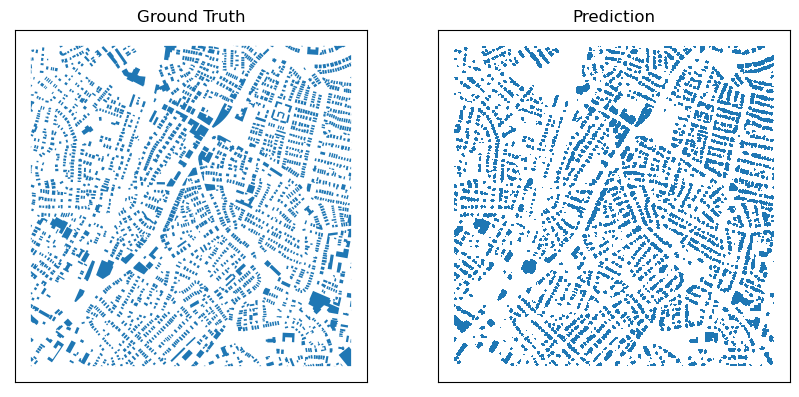

In [62]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))
y_shp.plot(ax=ax[0]); ax[0].set_xticks([]); ax[0].set_yticks([]); ax[0].set_title('Ground Truth')
y_hat_resc_shp.plot(ax=ax[1]); ax[1].set_xticks([]); ax[1].set_yticks([]); ax[1].set_title('Prediction')
plt.show()

In [63]:
# First compute confusion matrix terms
tp, tn, fp, fn = compute_confusion_matrix_shp(y_hat_resc_shp, y_shp, buffer=None, boundary=None)

# Then compute semantic segmentation metrics
metrics = ['iou', 'dice', 'ppv', 'tpr', 'tnr', 'fpr', 'fnr']
values = {m:eval(f'{m}({tp}, {tn}, {fp}, {fn})') for m in metrics}

# Show resulting metrics
shape_metrics_df = pd.DataFrame(values, index=[0])
shape_metrics_df

,iou,dice,ppv,tpr,tnr,fpr,fnr
0,0.52164,0.685629,0.62132,0.764786,0.873155,0.126845,0.235214


### 6. Generate pre-defined set of evaluation regions

In [19]:
# Generate evaluation regions (voronoi polygons).
y_shp_detailed = gpd.read_file(f'{data_path}/23578960_15_sub_gt_shapes.geojson') # In this case we need the detailed Ground Truth annotations (multiple polygons instead of a single multi-polygon)
voronoi_polygons = compute_voronoi_polygons(y_shp_detailed)

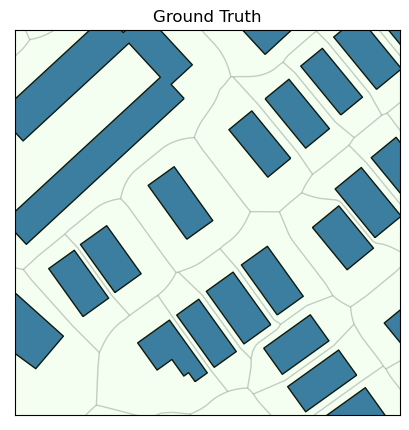

In [20]:
# Manually define a window to zoom in
minX, minY, maxX, maxY = 235900, 895600, 236000, 895700 

# Show Ground Truth annotations along with their corresponding evaluation regions
f, ax = plt.subplots(1, 1, figsize=(5, 5))

y_shp.plot(ax=ax, color='#3271a5', edgecolor='black')
voronoi_polygons.set_geometry('voronoi').plot(ax=ax, color='xkcd:light green', alpha=.1, edgecolor='black')
ax.set_xlim(minX, maxX); ax.set_ylim(minY, maxY); ax.set_title('Ground Truth'); ax.set_xticks([]); ax.set_yticks([])

plt.show()

### 7. Compute pixel-wise semantic segmentation metrics within evaluation regions

In [35]:
# Get predicted segmentation map in vector format. Important! we need each of the geometries individually, thats why simplify=False
with rasterio.open(f'{data_path}/23578960_15_y_pred_resc.tif') as src: 
    y_hat_resc_shp = np_to_shp(src.read(), transform=src.transform, crs=src.crs, simplify=False) 
    
buffer = 0
                            
m = y_shp_detailed.parallel_apply(lambda x: compute_object_metrics(x.geometry, x.level_1, voronoi_polygons, y_hat_resc_shp, buffer=buffer, buffer_kind='outer'), axis=1)
m_df = pd.DataFrame.from_records(m)

In [64]:
shape_metrics_df

,iou,dice,ppv,tpr,tnr,fpr,fnr
0,0.52164,0.685629,0.62132,0.764786,0.873155,0.126845,0.235214


In [58]:
m_df.loc[['avg']].iloc[[0], :7]

,iou_pos,dice_pos,ppv_pos,tpr_pos,tnr_pos,fpr_pos,fnr_pos
avg,0.778294,0.829321,0.94041,0.778294,0.94041,0.895345,0.162116


In [65]:
# As it can be seen there is a completly different scenario when assessing the performance of the model at the objet-level. We can then plot a bi-variate density distribution to
# gain a deeper intuition on which building sizes the model is performing better or worse.

### 8. Inspecting the performance at the object level thorugh the `Visualization` module

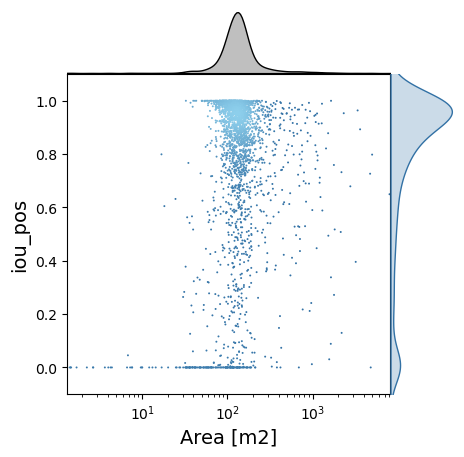

In [73]:
# Plot a bi-variate density distribution plot showing the relation between the IoU and the building size
gen_bivariate_plot(m_df, eval_attr='iou_pos')

In [ ]:
# As it can be seen most of the buildings are classified pretty well (IoU > .7). However, the model is struggling to detect small buildings and a few big ones.